In [381]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import glob
from scipy.integrate import solve_ivp
from multiprocessing import cpu_count, Pool

In [403]:
class DoubleSpring:
    """
    """
    def __init__(self, alpha_0=None, beta_0=None, t_end=2, dt=0.01):
        self.g = 9.81
        if alpha_0 is not None:
            self.alpha_0 = alpha_0
        else:
            self.alpha_0 = np.random.uniform(-np.pi, np.pi)
            
        if beta_0 is not None:
            self.beta_0 = beta_0
        else:
            self.beta_0 = np.random.uniform(-np.pi, np.pi)
        self.alpha_1 = 0.
        self.beta_1 = 0.
        
        self.a0 = 1.
        self.b0 = 1.
        self.a1 = 0.
        self.b1 = 0.
        self.dt = dt
        self.t_end = t_end
        
        self.l1 = 1.
        self.l2 = 1.
        self.m1 = 1.
        self.m2 = 1.
        self.k1 = 40.
        self.k2 = 50.
        
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0

    def _alpha_pp(self):
        # Y[0] = alpha_1, Y[1] = alpha_0
        return (-(self.g * self.m1 * np.sin(self.alpha_0) - self.k2 * self.l2 * np.sin(self.alpha_0 - self.beta_0) +
                  self.k2 * self.b0 * np.sin(self.alpha_0 - self.beta_0) + 
                  2 * self.m1 * self.a1 * self.alpha_1) / (self.m1 * self.a0))
    
    def _beta_pp(self):
        # Y[0] = beta_1, Y[1] = beta_0
        return ((-self.k1 * self.l1 * np.sin(self.alpha_0 - self.beta_0) + 
                 self.k1 * self.a0 * np.sin(self.alpha_0 - self.beta_0) -
                 2. * self.m1 * self.b1 * self.beta_1) / (self.m1 * self.b0))
    
    def _a_pp(self):
        # Y[0] = a1, Y[1] = a0
        return ((self.k1 * self.l1 + self.g * self.m1 * np.cos(self.alpha_0) - 
                 self.k2 * self.l2 * np.cos(self.alpha_0 - self.beta_0) + 
                 self.k2 * self.b0 * np.cos(self.alpha_0 - self.beta_0) + 
                 self.a0 * (-self.k1 + self.m1 * self.alpha_1 ** 2)) / self.m1)
    
    def _b_pp(self):
        # Y[0] = b1, Y[1] = b0
        return ((self.k2 * self.l2 * self.m1 + 
                 self.k2 * self.l2 * self.m2 * np.cos(self.alpha_0 - self.beta_0) +
                 self.k1 * self.m2 * self.a0 * np.cos(self.alpha_0 - self.beta_0) -
                 self.b0 * (self.k2 * (self.m1 + self.m2) - self.m1 * self.m2 * self.beta_1 ** 2)) / (self.m1 * self.m2))


    def integrate(self):
        t = 0
        storage = []
        while t < self.t_end:
            # Second-Order
            self.alpha_1 += self._alpha_pp() * self.dt
            self.beta_1 += self._beta_pp() * self.dt
            self.a1 += self._a_pp() * self.dt
            self.b1 += self._b_pp() * self.dt
            
            # First-Order
            self.alpha_0 += self.alpha_1 * self.dt
            self.beta_0 += self.beta_1 * self.dt
            self.a0 += self.a1 * self.dt
            self.b0 += self.b1 * self.dt
            
            t += self.dt
            storage.append([self.alpha_0, self.beta_0, self.a0, self.b0])
            
        return self.cartesian(np.array(storage))
    
    def cartesian(self, array):
        """
        """
        self.x1 = array[:, 2] * np.sin(array[:, 0])
        self.x2 = self.x1 + array[:, 3] * np.sin(array[:, 1])
        self.y1 = -array[:, 2] * np.cos(array[:, 0])
        self.y2 = self.y1 - array[:, 3] * np.cos(array[:, 1])
        return self.x1, self.y1, self.x2, self.y2
    
    def plot_spring(self):
        pass
    
    def animite_spring(self):
        pass
    
    def clear_figs(self):
        """
        """
        figs = glob.glob('*png')
        for f in figs:
            os.remove(f)
        

In [374]:
ds = DoubleSpring(dt=0.01, t_end=2.)
_ = ds.integrate()

In [375]:
colors_0 = np.zeros((ds.x1.shape[0], 4))
colors_1 = np.zeros((ds.x1.shape[0], 4))
alpha = np.linspace(0., 1., ds.x1.shape[0])
colors_0[:, 0] = 1.
colors_1[:, 2] = 1.
colors_0[:, 3] = alpha
colors_1[:, 3] = alpha

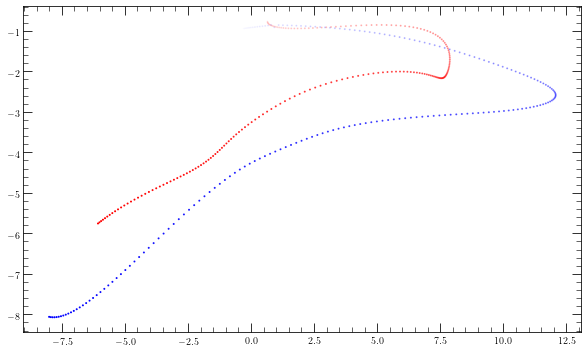

In [376]:
plt.figure(figsize=(10,6))
plt.scatter(ds.x1, ds.y1, color=colors_0, s=1)
plt.scatter(ds.x2, ds.y2, color=colors_1, s=1)
plt.show()

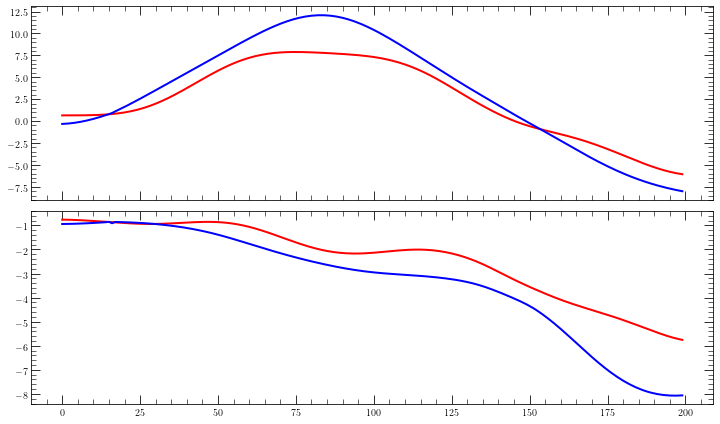

In [377]:
fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)
axs[0].plot(ds.x1, color='red')
axs[0].plot(ds.x2, color='blue')
axs[1].plot(ds.y1, color='red')
axs[1].plot(ds.y2, color='blue')
fig.tight_layout()
plt.show()

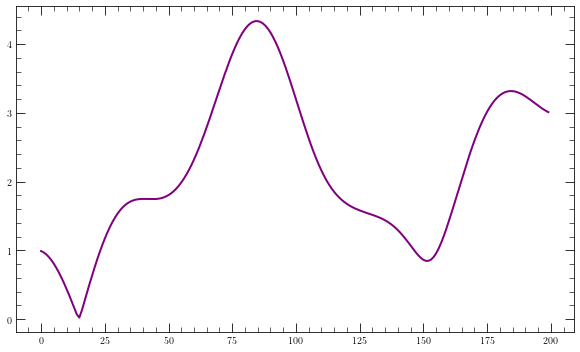

In [378]:
plt.figure(figsize=(10,6))
plt.plot(np.sqrt((ds.x1 - ds.x2) ** 2 + (ds.y1 - ds.y2) ** 2), color='purple')
plt.show()

In [379]:
ds.clear_figs()

In [380]:
def savefig(i, dpi=100):
    fig = plt.figure(figsize=(800./ dpi, 800./dpi), dpi=dpi)
    plt.plot(ds.x1[:i], ds.y1[:i], color='red', alpha=0.75, linestyle=':', zorder=0, linewidth=1.)
    plt.plot(ds.x2[:i], ds.y2[:i], color='blue', alpha=0.75, linestyle=':', zorder=0, linewidth=1.)
    plt.plot([0, ds.x1[i]], [0, ds.y1[i]], color='red', zorder=1)
    plt.plot([ds.x1[i], ds.x2[i]], [ds.y1[i], ds.y2[i]], color='blue', zorder=1)
    plt.scatter([0, ds.x1[i], ds.x2[i]], [0, ds.y1[i], ds.y2[i]], color=((0,0,0,1),(1,0,0,1),(0,0,1,1)), zorder=2)
    m1 = np.max([ds.x1, ds.x2])
    m2 = np.max([ds.y1, ds.y2])
    if m1 < 0:
        m1 = 2
    if m2 < 0:
        m2 = 2
    plt.xlim([np.min([ds.x1, ds.x2]), m1])
    plt.ylim([np.min([ds.y1, ds.y2]), m2])
    plt.savefig(str(i).zfill(5) + '.png', dpi=dpi)
    plt.clf()
    plt.close()

In [168]:
cores = cpu_count()
pool = Pool(processes=cores)

Process ForkPoolWorker-226:
Process ForkPoolWorker-227:
Process ForkPoolWorker-228:
Process ForkPoolWorker-229:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


In [169]:
_ = pool.map(savefig, np.arange(ds.x1.shape[0]))

In [74]:
#_ = pool.map(savefig, np.arange(4))

## Integration Library

In [860]:
class DoubleSpringInt:
    """
    """
    def __init__(self, alpha_0=None, beta_0=None, t_end=2, dt=0.01, fig_cache='_figs', cores=None):
        self.g = 9.81
        if alpha_0 is not None:
            self.alpha_0 = alpha_0
        else:
            self.alpha_0 = np.random.uniform(-np.pi, np.pi)
            
        if beta_0 is not None:
            self.beta_0 = beta_0
        else:
            self.beta_0 = np.random.uniform(-np.pi, np.pi)
            
        self.fig_cache = fig_cache
        if not os.path.exists(self.fig_cache):
            os.mkdir(self.fig_cache)
    
        self.alpha_1 = 0.
        self.beta_1 = 0.
        
        self.a0 = 1.
        self.b0 = 1.
        self.a1 = 0.
        self.b1 = 0.
        self.dt = dt
        self.t_end = t_end
        
        #
        self.l1 = 1.
        self.l2 = 1.
        self.m1 = 1.
        self.m2 = 1.
        self.k1 = np.random.uniform(35, 55)
        self.k2 = np.random.uniform(35, 55)
  
        self.t_eval = np.arange(0, self.t_end, self.dt)
        if cores is None:
            self.cores = cpu_count()
        else:
            self.cores = cores

    def _alpha_pp(self, t, Y):
        # Y[0] = alpha_1, Y[1] = alpha_0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, _ = Y
        return (-(self.g * self.m1 * np.sin(alpha_0) - self.k2 * self.l2 * np.sin(alpha_0 - beta_0) +
                  self.k2 * b0 * np.sin(alpha_0 - beta_0) + 
                  2 * self.m1 * a1 * alpha_1) / (self.m1 * a0))
    
    def _beta_pp(self, t, Y):
        # Y[0] = beta_1, Y[1] = beta_0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((-self.k1 * self.l1 * np.sin(alpha_0 - beta_0) + 
                 self.k1 * a0 * np.sin(alpha_0 - beta_0) -
                 2. * self.m1 * b1 * beta_1) / (self.m1 * b0))
    
    def _a_pp(self, t, Y):
        # Y[0] = a1, Y[1] = a0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((self.k1 * self.l1 + self.g * self.m1 * np.cos(alpha_0) - 
                 self.k2 * self.l2 * np.cos(alpha_0 - beta_0) + 
                 self.k2 * b0 * np.cos(alpha_0 - beta_0) + 
                 a0 * (-self.k1 + self.m1 * alpha_1 ** 2)) / self.m1)
    
    def _b_pp(self, t, Y):
        # Y[0] = b1, Y[1] = b0
        alpha_0, alpha_1, beta_0, beta_1, a0, a1, b0, b1 = Y
        return ((self.k2 * self.l2 * self.m1 + 
                 self.k2 * self.l2 * self.m2 * np.cos(alpha_0 - beta_0) +
                 self.k1 * self.m2 * a0 * np.cos(alpha_0 - beta_0) -
                 b0 * (self.k2 * (self.m1 + self.m2) - self.m1 * self.m2 * beta_1 ** 2)) / (self.m1 * self.m2))


    def _inte(self, t, Y):
        return [Y[1], self._alpha_pp(t, Y), Y[3], self._beta_pp(t, Y),
                Y[5], self._a_pp(t, Y), Y[7], self._b_pp(t, Y)]
    
    def integrate(self):
        Y0 = [self.alpha_0, self.alpha_1, self.beta_0, self.beta_1, self.a0, self.a1, self.b0, self.b1]
        self.solution = solve_ivp(self._inte, [0, self.t_end], Y0, t_eval=self.t_eval)
        self.cartesian(self.solution.y[[0, 2, 4, 6]].T)
        return self.solution
    
    def cartesian(self, array):
        """
        """
        self.x1 = array[:, 2] * np.sin(array[:, 0])
        self.x2 = self.x1 + array[:, 3] * np.sin(array[:, 1])
        self.y1 = -array[:, 2] * np.cos(array[:, 0])
        self.y2 = self.y1 - array[:, 3] * np.cos(array[:, 1])
        return self.x1, self.y1, self.x2, self.y2
    
    def _plot_settings(self, x):
        colors_0 = np.zeros((x.shape[0], 4))
        colors_1 = np.zeros((x.shape[0], 4))
        alpha = np.linspace(0.4, 0.8, x.shape[0]) ** 2.
        colors_0[:, 0] = 1.
        colors_1[:, 2] = 1.
        colors_0[:, 3] = alpha
        colors_1[:, 3] = alpha
        return colors_0, colors_1
    
    def plot_spring(self):
        colors_0, colors_1 = self._plot_settings()
        
        # Plot
        fig, ax = plt.subplots(figsize=(10,6))
        ax.scatter(self.x1, self.y1, color=colors_0, s=1)
        ax.scatter(self.x2, self.y2, color=colors_1, s=1)
        plt.show()
    
    def animate_spring(self, movie=False):
        self.clear_figs()
        pool = Pool(processes=self.cores)
        pool.map(self.save_frame, np.arange(self.x1.shape[0]))
        if movie:
            self.make_movie()
    
    def save_frame(self, i, dpi=100, trace=True, axes_off=True, size=800):
        colors_0, colors_1 = self._plot_settings(self.x1)
        fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi)
        if trace:
            plt.scatter(self.x1[:i], self.y1[:i], color=colors_0[:i], s=2., 
                        zorder=0)
            plt.scatter(self.x2[:i], self.y2[:i], color=colors_1[:i], s=2., 
                        zorder=0)
        plt.plot([0, self.x1[i]], [0, self.y1[i]], color='red', 
                 zorder=1)
        plt.plot([self.x1[i], self.x2[i]], [self.y1[i], self.y2[i]], 
                 color='blue', zorder=1)
        plt.scatter([0, self.x1[i], self.x2[i]], [0, self.y1[i], self.y2[i]], 
                    color=((0,0,0,1),(1,0,0,1),(0,0,1,1)), zorder=2)
        m1 = np.max([self.x1, self.x2])
        m2 = np.max([self.y1, self.y2])
        if m1 < 0:
            m1 = 2
        if m2 < 0:
            m2 = 2
        plt.xlim([np.min([self.x1, self.x2]), m1])
        plt.ylim([np.min([self.y1, self.y2]), m2])
        if axes_off:
            plt.axis('off')
        fig.set_size_inches(size/dpi, size/dpi, forward=True)
        fig.tight_layout()
        plt.savefig(os.path.join(self.fig_cache, str(i).zfill(5) + '.png'), dpi=dpi)
        plt.clf()
        plt.close()
    
    def clear_figs(self):
        """
        """
        figs = glob.glob(os.path.join(self.fig_cache, '*png'))
        for f in figs:
            os.remove(f)
            
    def make_movie(self, frame_rate=60):
        """
        """
        fname = 'dsp_{:.2f}_{:.2f}.mp4'.format(self.alpha_0, self.beta_0)
        fname = os.path.join(self.fig_cache, fname)
        figs = os.path.join(self.fig_cache, '%05d.png')
        os.system('ffmpeg -r {} -f image2 -s 1920x1080 -i {} -vcodec \
                    libx264 -crf 25  -pix_fmt yuv420p {}'.format(frame_rate, figs, fname))
        
        

In [425]:
arr = np.random.uniform(-np.pi, np.pi, size=2)

ds_org = DoubleSpring(dt=0.01, t_end=20., alpha_0=arr[0], beta_0=arr[1])
_ = ds_org.integrate()

ds = DoubleSpringInt(dt=0.01, t_end=20., alpha_0=arr[0], beta_0=arr[1])
sol = ds.integrate()

/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sin
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in cos
/Users/tyler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/Users/tyler/opt/anaconda3/lib/python3.7/site

In [427]:
colors_0 = np.zeros((x1.shape[0], 4))
colors_1 = np.zeros((x1.shape[0], 4))
alpha = np.linspace(0., 1., x1.shape[0])
colors_0[:, 0] = 1.
colors_1[:, 2] = 1.
colors_0[:, 3] = alpha
colors_1[:, 3] = alpha

In [428]:
def cum_mean(arr):
    cum_sum = np.cumsum(arr, axis=0)    
    for i in range(cum_sum.shape[0]):       
        if i == 0:
            continue        
        cum_sum[i] =  cum_sum[i] / (i + 1)
    return cum_sum

## Test Functions

In [556]:
ds = DoubleSpringInt(dt=1. / 60., t_end=10.)
_ = ds.integrate()

In [558]:
ds.animate_spring(movie=True)

Process ForkPoolWorker-426:
Process ForkPoolWorker-427:
Process ForkPoolWorker-428:
Process ForkPoolWorker-425:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/tyler/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self.

In [867]:
def _plot_settings(x):
        colors = np.zeros((x.shape[0], 4))
        colors[:, 2] = 1
        alpha = np.linspace(0.2, 0.8, x.shape[0]) ** 2.
        colors[:, 3] = alpha
        return colors
    
def _plot_settings_2(x):
        colors_0 = np.zeros((x.shape[0], 4))
        colors_1 = np.zeros((x.shape[0], 4))
        alpha = np.linspace(0.4, 0.8, x.shape[0]) ** 2.
        colors_0[:, 3] = alpha
        colors_1[:, 3] = alpha
        return colors_0, colors_1
    
def save_frame(fig, d, i, trace=True, axes_off=True):
    colors = _plot_settings(d.x1[:i])

    if trace:
        plt.scatter(d.x2[:i], d.y2[:i], color=colors[:i], s=2., 
                    zorder=0)
        
    if axes_off:
        plt.axis('off')
        
    plt.plot([0, d.x1[i]], [0, d.y1[i]], color='black', 
             zorder=1, linewidth=1., alpha=0.7)
    plt.plot([d.x1[i], d.x2[i]], [d.y1[i], d.y2[i]], 
             color='blue', zorder=1, linewidth=1., alpha=0.7)
    plt.scatter([0, d.x1[i], d.x2[i]], [0, d.y1[i], d.y2[i]], 
                color=((0,0,0,1),(0,0,0,1),(0, 0, 1, 1)), zorder=2)
    
def save_frame_2(fig, d, i, trace=True, axes_off=True):
    _, colors_1 = _plot_settings_2(d.x1)

    if trace:
        plt.plot(d.x2[:i], d.y2[:i], color=colors_1, linewidth=0.75, 
                    zorder=0)
        
    if axes_off:
        plt.axis('off')
    
def clear_figs(fig_cache):
    """
    """
    figs = glob.glob(os.path.join(fig_cache, '*png'))
    for f in figs:
        os.remove(f)

In [868]:
ps = np.random.uniform(-np.pi, np.pi, size=2)
alpha = ps[0]
beta = np.linspace(ps[1], ps[1] + 0.15, 10)
ds_s = []

for b in beta:
    ds = DoubleSpringInt(dt=1. / 30., t_end=15., alpha_0=alpha, beta_0=b)
    _ = ds.integrate()
    ds_s.append(ds)

In [869]:
mini_x, maxi_x = 0, -10
mini_y, maxi_y = 0, -10

for d in ds_s:
    if np.min([d.x1, d.x2]) < mini_x:
        mini_x = np.min([d.x1, d.x2])
    if np.max([d.x1, d.x2]) > maxi_x:
        maxi_x = np.max([d.x1, d.x2])
    if np.min([d.y1, d.y2]) < mini_y:
        mini_y = np.min([d.y1, d.y2])
    if np.max([d.y1, d.y2]) > maxi_y:
        maxi_y = np.max([d.y1, d.y2])

In [870]:
def main(i):
    dpi = 100
    size = 712
    fig_cache = '_figs'
    fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi)
    for d in ds_s:
        save_frame(fig, d, i)
    fig.set_size_inches(size/dpi, size/dpi, forward=True)
    plt.xlim([mini_x * 1.05, maxi_x * 1.05])
    plt.ylim([mini_y * 1.05, maxi_y * 1.05])
    fig.tight_layout()
    plt.savefig(os.path.join(fig_cache, str(i).zfill(5) + '.png'), dpi=dpi)
    plt.clf()
    plt.close()

In [871]:
fig_cache = '_figs'
clear_figs(fig_cache)
pool = Pool(processes=cpu_count())
_ = pool.map(main, np.arange(ds_s[0].x1.shape[0]))

In [872]:
frame_rate = 30
fname = os.path.join('chaos.mp4')
figs = os.path.join(fig_cache, '%05d.png')
os.system('ffmpeg -r {} -f image2 -s 1920x1080 -i {} -vcodec \
            libx264 -crf 25  -pix_fmt yuv420p {}'.format(frame_rate, figs, fname))

0